# Lung Cancer detection using the VNet architecture

In [11]:
# Importing the required libs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage

from skimage import morphology, measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


root_dir = '/Users/navneetmkumar/Documents/Paper Implementations'
sample_images_dir = root_dir+'/sample_images/'
print(sample_images_dir)
patients = os.listdir(sample_images_dir)
patients.sort()
patients = patients[1:]

/Users/navneetmkumar/Documents/Paper Implementations/sample_images/


In [2]:
# Load the scans in the given folder path
def load_scan(path):
    slices = [dicom.read_file(path+'/'+s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # Pixel data in the z axis ie the thickness of the slice is missing
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
# Unit for measurement in CT scans is Hounsfiled Units(HU) but by default this is not the unit returned.
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        
    return np.array(image, dtype=np.int16)

00cba091fa4ad62cc3200a657aeb957e


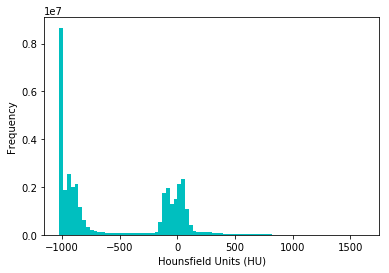

In [12]:
# Testing
print(patients[0])
first_patient = load_scan(sample_images_dir+patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

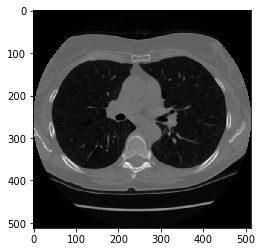

In [13]:
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

# Resampling
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

In [14]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    print(spacing)
    resize_factor = spacing/ new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape/ image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing    

In [15]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

[ 2.5         0.59765601  0.59765601]
Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


In [17]:
second_patient = load_scan(sample_images_dir+patients[1])
second_patient_pixels = get_pixels_hu(second_patient)

pix_resampled_second, sec_spacing = resample(second_patient_pixels, second_patient, [1,1,1])
print("Shape before resampling\t", second_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled_second.shape)

[ 2.5         0.67773402  0.67773402]
Shape before resampling	 (128, 512, 512)
Shape after resampling	 (320, 347, 347)


# 3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. 

In [20]:
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p  = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p,threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

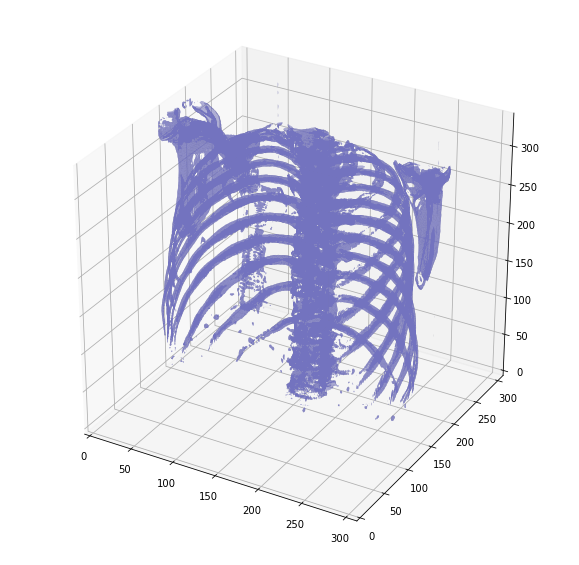

In [21]:
plot_3d(pix_resampled, 400)